In [2]:
import os
import sys
import glob as gb
import re
from pathlib import Path

import numpy as np
import pandas as pd

from PIL import Image

from sklearn.preprocessing import MinMaxScaler

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
import matplotlib.image as mpimg
mpl.style.use('classic')

import pydicom as dcm
import pylab

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

# General settings

In [3]:
# See https://stackoverflow.com/questions/14722540/smoothing-between-pixels-of-imagesc-imshow-in-matlab-like-the-matplotlib-imshow
mpl.rcParams['image.interpolation'] = 'none' # default 'bilinear'

layout=Layout(width='90%') # For ipywidgets

In [4]:
home = str(Path.home())
data_dir = f"{home}/data/aneurysm/"
PATH = Path(data_dir)
# STL
stl_dir = f"{home}/data/aneurysm/stls.ours/"

# Dicom
dcm_dir = f"{home}/data/aneurysm/512Auto.ours/"
mask_dir = f"{home}/data/aneurysm/512Auto.ours.masks/"

# PNG
pngs_dir = f"{home}/data/aneurysm/train-512/"
masks_pngs_dir = f"{home}/data/aneurysm/train_masks-512/"

dirs = [data_dir,mask_dir,stl_dir,dcm_dir,pngs_dir,masks_pngs_dir]

In [5]:
# for d in dirs:
#      !mkdir -p {d}
!tree --filelimit=12 {data_dir}
!pwd

/home/amer/data/aneurysm/
├── 512Auto.masks.pngs.tar.gz
├── 512Auto.ours [67 entries exceeds filelimit, not opening dir]
├── 512Auto.ours.masks [67 entries exceeds filelimit, not opening dir]
├── 512Auto.pngs.tar.gz
├── models
│   └── tmp.h5
├── stls.ours
│   ├── A012.stl
│   ├── A013.stl
│   ├── A015.stl
│   └── A016.stl
├── tmp
├── train-128 [29232 entries exceeds filelimit, not opening dir]
├── train-512 [29232 entries exceeds filelimit, not opening dir]
├── train_masks-128 [29232 entries exceeds filelimit, not opening dir]
└── train_masks-512 [29232 entries exceeds filelimit, not opening dir]

9 directories, 7 files
/home/amer/Code/ML_for_Medical_Image_Processing


In [6]:
!ls -1 {pngs_dir} | wc -l 

29232


# Data exploration

In [7]:
reg_complete_filename = re.compile("[^/]*$") # Match a file name in a path
reg_filename = re.compile("^([^.]+)") # Match a file name in a path

def get_filename(paths,num):
    complete_filename = re.search(reg_complete_filename, paths[num]).group(0)
    return re.search(reg_filename, complete_filename).group(0)
    
def get_dicoms_paths(source_dir):
    return sorted(gb.glob(f"{source_dir}*.dcm"))

In [8]:
def get_pngs(dicoms_paths,dcm_num):
    ds = dcm.read_file(dicoms_paths[dcm_num]) # get the dicom file #dcm_num
    return ds.pixel_array

# Shows one image
def browse_dicom(source_dir,dicom_num):
    dicoms_paths = get_dicoms_paths(source_dir)
    pngs = get_pngs(dicoms_paths,dicom_num)
    last = len(pngs)-1
    print(dicoms_paths[dicom_num])
    def show_png(num):
        pylab.imshow(pngs[num],cmap=pylab.cm.bone)
    interact(show_png, num=widgets.IntSlider(min=0,max=last,step=1,layout=layout));

# Shows original and mask side by side
def browse_dicom_and_mask(original_dir,mask_dir,dicom_num):
    original_paths = get_dicoms_paths(original_dir)
    mask_paths = get_dicoms_paths(mask_dir)
    
    original_pngs = get_pngs(original_paths,dicom_num)
    mask_pngs = get_pngs(mask_paths,dicom_num)
    
    last = len(original_pngs)-1
    print(original_paths[dicom_num])
    print(mask_paths[dicom_num])
    def show_png(num):
        f = plt.figure(figsize=(20,10))
        f.add_subplot(1,2, 1)
        pylab.imshow(original_pngs[num],cmap=pylab.cm.bone)
        f.add_subplot(1,2, 2)
        pylab.imshow(mask_pngs[num],cmap=pylab.cm.bone)
        plt.show(block=True)
    interact(show_png, num=widgets.IntSlider(min=0,max=last,step=1,layout=layout))

In [9]:
browse_dicom_and_mask(dcm_dir,mask_dir,10)

/home/amer/data/aneurysm/512Auto.ours/A025.dcm
/home/amer/data/aneurysm/512Auto.ours.masks/A025.mask.dcm


interactive(children=(IntSlider(value=0, description='num', layout=Layout(width='90%'), max=438), Output()), _…

In [10]:
#browse_dicom(dcm_dir,1) # Show me the MRI Dicom file #2
#browse_dicom(mask_dir,1) # Show me the Mask Dicom file #2

In [11]:
def save_dicom_to_pngs(source_dir,target_dir,dicom_num):
    paths = get_dicoms_paths(source_dir)
    dicom_file_name = get_filename(paths,dicom_num)
    pngs = get_pngs(paths,dicom_num)
    slice_count = len(pngs)-1
    for i in range(dicom_num,slice_count):
        pylab.imsave(f"{target_dir}{dicom_file_name}_{i}",pngs[i],cmap=pylab.cm.bone)
    return slice_count+1

In [12]:
def breakup_dicom(source_dir,target_dir): # Dicom to pngs
    dicom_paths = get_dicoms_paths(source_dir) # Get dicoms files
    file_count = len(dicom_paths) # Count dicom files
    for i in range(0,file_count):
        print(f"Breaking up {get_filename(dicom_paths,i)} into pngs...")
        slice_num = save_dicom_to_pngs(source_dir,target_dir,i)
        print(f"Finished {get_filename(dicom_paths,i)}! {slice_num} slices were saved.\n")
    print(f"PNGs are in {pngs_dir}")

In [13]:
#breakup_dicom(dcm_dir,pngs_dir)

In [14]:
#breakup_dicom(mask_dir,masks_pngs_dir)

In [15]:
# return the dicom file as a numpy array
# @index is the index of the file in "dcm_dir" directory
def dicom_as_tensor(index):
    return get_pngs(get_dicoms_paths(dcm_dir),index)

def mask_as_tensor(index):
    return get_pngs(get_dicoms_paths(mask_dir),index)

In [16]:
def show_scaled_dicom(source_dir,dcm_index):
    dicoms_paths = get_dicoms_paths(source_dir)
    dcm = get_pngs(dicoms_paths,dcm_index)
    last = last = len(dcm)-1
    print(last)
    def show_img(num):
        _slice = dcm[num]
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler.fit(_slice)
        scaled = scaler.transform(_slice)
        plt.figure(figsize=(8,8))
        pylab.imshow(scaled,cmap=pylab.cm.bone)
    interact(show_img, num=widgets.IntSlider(min=0,max=last,step=1,layout=layout));

In [17]:
show_scaled_dicom(dcm_dir,6)

438


interactive(children=(IntSlider(value=0, description='num', layout=Layout(width='90%'), max=438), Output()), _…

In [18]:
tensor = dicom_as_tensor(3)[0]
# print(np.shape(tensor))
# w = 200 # window1
# m = 1 # stried
print(np.shape(tensor))
#print(tensor[m:m+w,m:m+w])
# plt.figure(figsize=(8,8))
# pylab.imshow(tensor,cmap=pylab.cm.bone)

(512, 512)


In [19]:
tensor = dicom_as_tensor(3)[0]
# Sliding window
def tensor_window(tensor):
    height = np.shape(tensor)[0]
    width = np.shape(tensor)[1]
    def move_window(x,y,w):
        print(np.shape(tensor))
        print(f'[x-w:x,y-w:y]: [{max([x-w,0])}:{x},{max([y-w,0])}:{y}]')
        wx = max([x-w,0])
        wy = max([y-w,0])
        print(f'Window= {w}x{w}')
        t = tensor[wx:x,wy:y]
        pylab.imshow(t,cmap=pylab.cm.bone)
    s = 1 # stried
    interact(move_window,
             x=widgets.IntSlider(min=40,max=height,step=s,layout=layout),
             y=widgets.IntSlider(min=40,max=width,step=s,layout=layout),
             w=widgets.IntSlider(min=40,max=512,step=1,layout=layout),)
    
    
tensor_window(tensor)

interactive(children=(IntSlider(value=40, description='x', layout=Layout(width='90%'), max=512, min=40), IntSl…

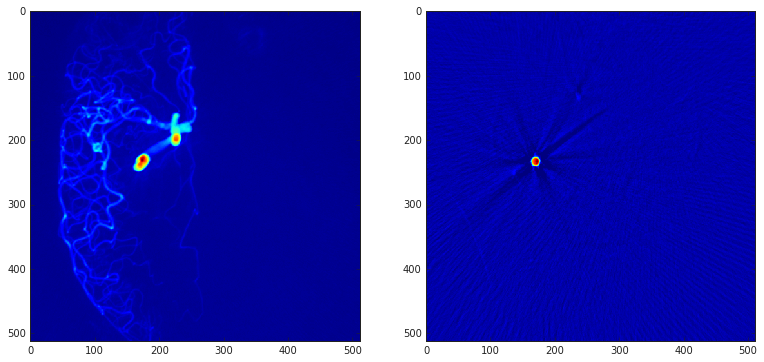

In [20]:
# Slices sum
img_id = 3
slice_index = 0 # First slice
slices_to_sum = 439 # Starting from the slice number slice_index

slice_ = np.std(dicom_as_tensor(img_id)[slice_index:slice_index+slices_to_sum],axis=0)

f = plt.figure(figsize=(13,10))
f.add_subplot(1,2, 1)
plt.imshow(slice_)
f.add_subplot(1,2, 2)
plt.imshow(dicom_as_tensor(3)[slice_index])

# The Deep Learning module

In [21]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [22]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
torch.cuda.set_device(0)

# Read and show PNG functions

/home/amer/data/aneurysm/train-512/A049_216.png
/home/amer/data/aneurysm/train_masks-512/A049_216.png


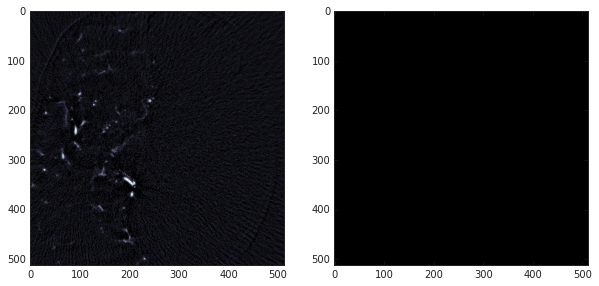

In [23]:
images = list(Path(pngs_dir).iterdir())
masks = list(Path(masks_pngs_dir).iterdir())

img_id = 300

# @kind "I" for Images or "M" for masks
def get_path(index=0,kind="I"):
    if kind == "I":
        return str(images[index])
    else:
        return str(masks[index])

def read_png(index=0,kind="I"):
    if kind == "I":
        return mpimg.imread(get_path(index,kind="I"))
    else:
        return mpimg.imread(get_path(index,kind="M"))

def show_png(index=0,kind="I"):
    if kind == "I":
        plt.imshow(read_png(index,kind="I"))
    else:
        plt.imshow(read_png(index,kind="M"))


index = 5444

print(get_path(index,kind="I"))
print(get_path(index,kind="M"))

f = plt.figure(figsize=(10,10))
f.add_subplot(1,2, 1)
show_png(index=index,kind="I")
f.add_subplot(1,2, 2)
show_png(index=index,kind="M")

# Mask processing

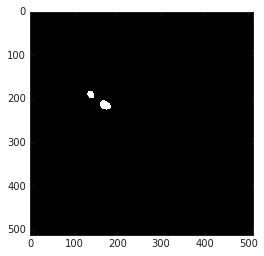

In [24]:
index = 8583
show_png(index,kind="M")

In [25]:
mk = read_png(index,kind="M")
mk = mk.astype('uint8')
np.shape(mk)

(512, 512, 4)

In [26]:
# Examine Mask channels and values

def channels_info(channels):
    for c in channels:
        print(str(np.unique(c))[:100])
        print(np.shape(c),end="\n\n")

def get_channels(img):
    channels_num = np.shape(mk)[2]
    return [img[:,:,i] for i in range(0,channels_num)]

channels_info(get_channels(mk))

[0 1]
(512, 512)

[0 1]
(512, 512)

[0 1]
(512, 512)

[1]
(512, 512)



In [27]:
mk[mk > 0] = 1
channels_info(get_channels(mk))

[0 1]
(512, 512)

[0 1]
(512, 512)

[0 1]
(512, 512)

[1]
(512, 512)



In [28]:
# Remove the 1s channel
mk = mk[:,:,:3]
channels_info(get_channels(mk))

[0 1]
(512, 512)

[0 1]
(512, 512)

[0 1]
(512, 512)



In [29]:
mk = np.max(mk,axis=2)# Combine all the three channels

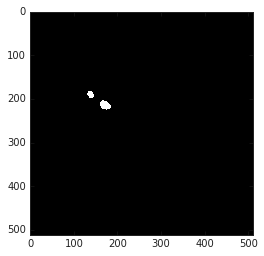

In [30]:
plt.imshow(mk,"gray")

# Resize PNG

In [31]:
(PATH/'train_masks-128').mkdir(exist_ok=True)
(PATH/'train-128').mkdir(exist_ok=True)

In [32]:
!ls {PATH}

512Auto.masks.pngs.tar.gz  512Auto.pngs.tar.gz	tmp	   train_masks-128
512Auto.ours		   models		train-128  train_masks-512
512Auto.ours.masks	   stls.ours		train-512


In [33]:
# Will return indexs of nonempty masks
def find_nonempty_masks(files):
    for i in range(0,len(files)):
        fn = files[i]
        str(fn)
        mk = mpimg.imread(str(fn))
        mk = mk[:,:,:3]
        mk = mk.astype('uint8')
        if np.sum(mk) > 0:
            print(i,end=", ",)

# find the nonempty masks in the first 100 files
files = list((PATH/'train_masks-512').iterdir())[:100] 
find_nonempty_masks(files)

11, 12, 23, 24, 32, 35, 38, 39, 41, 42, 45, 47, 58, 59, 60, 67, 68, 70, 75, 78, 79, 82, 84, 94, 96, 98, 99, 

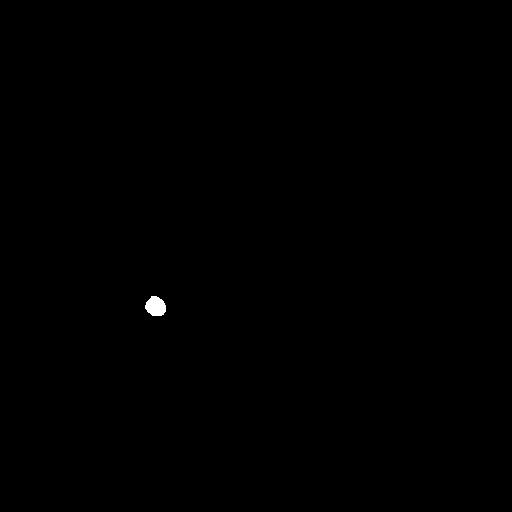

In [34]:
def clean_mask(fn):
    mk = mpimg.imread(str(fn)) # read the file as a np.array
    mk = mk[:,:,:3] # Remove the ones channel
    mk = mk.astype('uint8') # change type
    mk[mk > 0] = 255 # none zero is 255. (Binary classes)
    mk = np.max(mk,axis=2) # Combine all the three channels in one channel
    return Image.fromarray(mk)# return as an image object

# plt.imshow(mk*255,"binary")

fn = list((PATH/'train_masks-512').iterdir())[98]
clean_mask(fn)

In [35]:
def resize_mask(fn):
    clean_mask(fn).resize((128,128)).save((fn.parent.parent)/'train_masks-128'/fn.name)

# files = list((PATH/'train_masks-512').iterdir())
# with ThreadPoolExecutor(8) as e: e.map(resize_mask, files)

In [36]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train-128'/fn.name)

# files = list((PATH/'train-512').iterdir())
# with ThreadPoolExecutor(6) as e: e.map(resize_img, files)

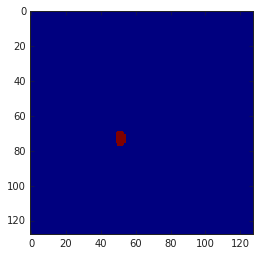

In [37]:
fn = files[99]
m = plt.imread(str((fn.parent.parent)/'train_masks-128'/fn.name))
plt.imshow(m)

# Remove misleading images with wrong masks

In [38]:
def get_dicom_files_names_from_pngs():
    return np.unique([re.sub(r"_.*", "", x.parts[-1]) for x in (PATH/'train_masks-512/').rglob("*.png")])

files_ids = get_dicom_files_names_from_pngs()
files_ids

array(['A012', 'A013', 'A015', 'A016', 'A017', 'A018', 'A019', 'A022', 'A023', 'A024', 'A025', 'A027',
       'A029', 'A031', 'A032', 'A033', 'A036', 'A040', 'A041', 'A042', 'A043', 'A046', 'A047', 'A049',
       'A050', 'A051', 'A054', 'A057', 'A064', 'A065', 'A066', 'A067', 'A071', 'A072', 'A074', 'A075',
       'A077', 'A080', 'A081', 'A082', 'A083', 'A084', 'A086', 'A087', 'A088', 'A089', 'A091', 'A092',
       'A093', 'A095', 'A097', 'A098', 'A100', 'A101', 'A103', 'A107', 'A109', 'A112', 'A115', 'A123',
       'A126', 'A133', 'A134', 'A135', 'A137'], dtype='<U4')

In [39]:
mask_tensor = mask_as_tensor(10)

# Observation: In the most if not all of the dicom files
# labels are missing for the first slices even the artery is clearly there
# This function returns from which slice the leabling started
# For mask #6 = 54
# For mask #10 = 124
# Every mask before this number is misleading
# @tensor (512x512)
def get_first_nonempty_slice_index(tensor):
    last = np.shape(tensor)[0]
    for i in range(0,last):
        max_val = np.max(tensor[i])
        if max_val > 0:
            return i
        
get_first_nonempty_slice_index(mask_tensor)

124

In [40]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

# Balancing dataset

In [107]:

def split_empty_nonempty_datapoints(files):
    empty = np.array([]).astype('uint8')
    nonempty = np.array([]).astype('uint8')
    for idx,f in enumerate(files):
        mk = mpimg.imread(str(f))
        if np.argmax(mk) > 0:
            nonempty = np.append(nonempty,idx)
        else:
            empty = np.append(empty,idx)
    return empty,nonempty

# # Will return indexs of nonempty masks
# def find_nonempty_masks(files):
#     for i in range(0,len(files)):
#         fn = files[i]
#         mk = mpimg.imread(str(fn))
#         mk = mk[:,:,:3]
#         mk = mk.astype('uint8')
#         if np.sum(mk) > 0:
#             print(i,end=", ",)


files = list((PATH/'train_masks-128').iterdir())
empty,nonempty = split_empty_nonempty_datapoints(files)

In [137]:
#print("empty:",len(empty),"nonempty:",len(nonempty))
empty_subset = np.random.choice(empty,len(nonempty)) # choice random subset from empty that equals to the siez of nonempty
balanced_idx = np.append(nonempty,empty_subset)
np.random.shuffle(balanced_idx)
balanced_idx

array([25639, 16887,  6888, ..., 13102,  4538,  7905])

In [138]:
print("balanced:",len(balanced_idx),"empty:",len(empty),"nonempty:",len(nonempty))

balanced: 18706 empty: 19879 nonempty: 9353


# Dataset

In [114]:
TRAIN_DN = f'{home}/data/aneurysm/train-128'
MASKS_DN = f'{home}/data/aneurysm/train_masks-128'
sz = 128
bs = 64

In [115]:
def get_png_paths(source_dir):
    return sorted(gb.glob(f"{PATH/source_dir}/*.png"))

# Shows img and mask side by side
def browse_png_and_mask(original_dir,mask_dir,dicom_num):
    
    original_pngs = get_png_paths(original_dir)
    mask_pngs = get_png_paths(mask_dir)
    
    last = len(original_pngs)-1

    def show_png_(num):
        f = plt.figure(figsize=(10,10))
        f.add_subplot(1,2, 1)
        print(original_pngs[num])
        print(mask_pngs[num])
        pylab.imshow(plt.imread(original_pngs[num]))
        f.add_subplot(1,2, 2)
        pylab.imshow(plt.imread(mask_pngs[num]))

    interact(show_png_, num=widgets.IntSlider(min=0,max=last,step=1,layout=layout))

browse_png_and_mask(str(PATH/TRAIN_DN),str(PATH/MASKS_DN),0)

interactive(children=(IntSlider(value=0, description='num', layout=Layout(width='90%'), max=29231), Output()),…

In [139]:
class MatchedFilesDataset (FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [140]:
#file_names = np.array([f.name for f in (PATH/TRAIN_DN).rglob("*.png")])

In [141]:
x_names = np.array(list((PATH/TRAIN_DN).iterdir()))
y_names = np.array(list((PATH/MASKS_DN).iterdir()))

In [142]:
# Filter a part of the empty masks
x_names = np.take(x_names, balanced_idx)
y_names = np.take(y_names, balanced_idx)

In [143]:
!ls {x_names[13000]}
!ls {y_names[13000]}

/home/amer/data/aneurysm/train-128/A064_180.png
/home/amer/data/aneurysm/train_masks-128/A064_180.png


In [144]:
val_percentage = int(np.round(len(x_names) * 0.2)) # 20% of data is validation set
val_idxs = list(range(3000))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [145]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [146]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

# Simple upsample

In [147]:
f = resnet34
cut,lr_cut = model_meta[f]

In [148]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [149]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [150]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [151]:
class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.features = nn.Sequential(
            rn, nn.ReLU(),
            StdUpsample(512,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            nn.ConvTranspose2d(256, 1, 2, stride=2))
        
    def forward(self,x): return self.features(x)[:,0]

In [152]:
class  UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model.features)[1:]]

In [153]:
m_base = get_base()

In [154]:
m = to_gpu(Upsample34(m_base))
models = UpsampleModel(m)

In [155]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [156]:
learn.freeze_to(1)

 87%|████████▋ | 213/246 [00:56<00:08,  3.75it/s, loss=0.462] 

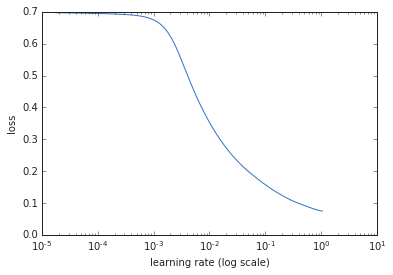

In [157]:
learn.lr_find()
learn.sched.plot()

In [110]:
learn.sched.best

0.01963078476279964

In [116]:
4e-2

0.04

In [117]:
lr=4e-2
wd=1e-7

lrs = np.array([lr/100,lr/10,lr])/2

In [120]:
learn.fit(lr,1, wds=wd, cycle_len=10,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice             
    0      0.227687   0.450245   0.998526   0.15197   
  3%|▎         | 12/410 [00:10<05:39,  1.17it/s, loss=0.254]

KeyboardInterrupt: 

In [119]:
learn.save('tmp')

In [ ]:
learn.load('tmp')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.fit(lrs,1,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.save('128')

In [ ]:
show_img(py[39]>0);

In [ ]:
show_img(y[39]);